# Hyperparameter exploration

We're continuing our exploration of hyperparameters. These are choices you as a researcher have to make when constructing your model and we will see that the choice depends highly on a given data case. In this notebook, we are going to use our circles dataset again and see how not only the kernel but all hyperparameters affect our outcome.

## Dataset

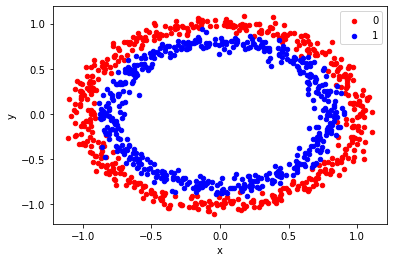

In [1]:
# Start by creating our own data again.

import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=1000, noise=0.05)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

# Fitting neural network

Split into train/test again.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Now, let's run the same model with linear kernel as before:

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

input_dim = X_train.shape[1]
output_dim = 1

model = Sequential()
model.add(Dense(50,input_dim=input_dim))
model.add(Activation('linear'))
model.add(Dense(50))
model.add(Activation('linear'))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

model.fit(X_train,y_train,epochs=10)

prediction_prob = model.predict(X_test)
prediction_class = (prediction_prob > 0.5).astype("int32")


print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainabl

2022-12-01 12:19:09.870767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 12:19:09.870808: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 12:19:09.870839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noteable): /proc/driver/nvidia/version does not exist
2022-12-01 12:19:09.871147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


22/22 [==============================] - 0s 1ms/step - loss: 0.7106 - accuracy: 0.4843
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 0.7047 - accuracy: 0.4843
Epoch 3/10
22/22 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.4929
Epoch 4/10
22/22 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.4871
Epoch 5/10
22/22 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.4971
Epoch 6/10
22/22 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.4857
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4857
Epoch 8/10
22/22 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.4943
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5143
Epoch 10/10
10/10 [==============================] - 0s 949us/step
Accuracy: 0.47
AUC: 0.45384239299524426


That's the same code from before and as you will remember the performance is pretty bad. Our neural network is currently just performing the same as random (0.5) or even worse than that.

To visualise our results:

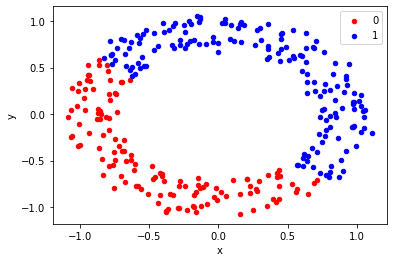

In [5]:
df = pd.DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=prediction_class[:,0]))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Clearly our model is just drawing a linear classifier through that dataset, which doesn't work. 

## Different hyperparameters

Let's explore a range of hyperparameters. More specifically, we will focus on:
- Activation function
- Number of neurons in a hidden layer
- Number of layers
- Learning rate
- Number of epochs

First we create the model:

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam

def nn_model(no_neurons,learning_rate,no_layers,kernel): # note how we specify parameters that we will search for later here
    model = Sequential() # we know this part from our basic network building exercise
    model.add(Dense(no_neurons,input_dim=input_dim)) # the number of neurons will be decided through grid search and we know the input dimension
    model.add(Activation(kernel)) # the activation kernel will also be decided through grid search

    # Extra hidden layers; the number of layers will be optimised
    for _ in range(0,no_layers):
        model.add(Dense(no_neurons))
        model.add(Activation(kernel))

    # Output
    model.add(Dense(output_dim))
    model.add(Activation('sigmoid')) # we're trying to predict a probability for a two-class problem
    model.compile(optimizer=Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
        
    return model

Next, we run the grid search.

This might take quite a while, so be patient!

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# specify which choices could be made here;
parameters = {'no_neurons':[50,100],'kernel':['relu','sigmoid','linear'],'no_layers':[1,2],'learning_rate':[0.1,0.01,0.001],'epochs':[10,20],'verbose':[0]} 

grid_search = GridSearchCV(KerasClassifier(nn_model), parameters, cv=5,scoring='roc_auc')
grid_search.fit(X_train, y_train.ravel())

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

print('Mean AUC (+/- standard deviation), for parameters')
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/- %0.03f) for %r"
          % (mean, std, params))

/tmp/ipykernel_1573/1276641437.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_search = GridSearchCV(KerasClassifier(nn_model), parameters, cv=5,scoring='roc_auc')


5/5 [==============================] - 0s 1ms/step
Mean AUC (+/- standard deviation), for parameters
0.984 (+/- 0.013) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 50, 'verbose': 0}
0.979 (+/- 0.009) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 100, 'verbose': 0}
0.792 (+/- 0.210) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 50, 'verbose': 0}
0.974 (+/- 0.008) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 100, 'verbose': 0}
0.989 (+/- 0.010) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 50, 'verbose': 0}
0.987 (+/- 0.008) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 100, 'verbose': 0}
0.993 (+/- 0.004) for {'epochs': 10, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 2, 'no_neurons': 50, 'verbose': 0}
0.976 (+/- 0.012) 

Again, we see that the ReLU kernel clearly outperforms the linear and sigmoid one (although the sigmoid one is slightly higher and above 50% compared to the linear kernel).

The influence of epochs and learning rate is a bit more difficult to see. The middle learning rate (0.01), however, tends to result in the highest AUC.

The structure of the network (number of layers and number of neurons) seems to have a much smaller impact on the final results. You might remember from the lecture that the depth of the network and the number of neurons is particularly important for very complex classification problems; this might not be the situation here which means that a simpler architectue works just fine.